# Cognition and computation project

 Name and surname : Roman Gellert
 
 Matricola N. : 2109260
 
 Dataset : omniglot
 
 Date : 16.01.2024

# Approach

I have decided to take a little bit of challenge and try to build an DBN using the omniglot dataset

After studying the dataset I found out the following: 
- There are 964 various letters and some of them are really similar to each other, sometimes even being basically the same letter.
- There are 19280 training samples and ~20 test samples of each letter (which is in my opinion very low for such a task)

Which seriously complicates things both for my system (NVIDIA GeForce GTX 1050 GPU) and the DBN architecture implemented in the DBN library

Therefore, I have decided to simplify the task a bit by:
- Reducing the number of labels to 20 (still fairly challenging letters)
- Performing data augmentation to add some variance and increase the training and test datasets. (To hopefully reduce the effect of overfitting)

## Table of contents
1. Data Augmentation

In [63]:
# library imports
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize
from torchvision.transforms import Compose
from torchvision.transforms import v2
import torch.nn.functional as functional
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from DBN import DBN

In [18]:
# checking if cuda is available and choosing it to speed up computing
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [154]:
# transforming the images to 40 X 40 pixels
transform = Compose([
    Resize([40, 40]),
    ToTensor()
])

omniglot_tr = tv.datasets.Omniglot(root="../omniglot", download=True, background=True, transform=transform)
omniglot_te = tv.datasets.Omniglot(root="../omniglot", download=True, background=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(omniglot_tr)

19280

In [5]:
len(omniglot_te)

13180

# Original dataset

Here i looak at the original dataset and preprocess the data

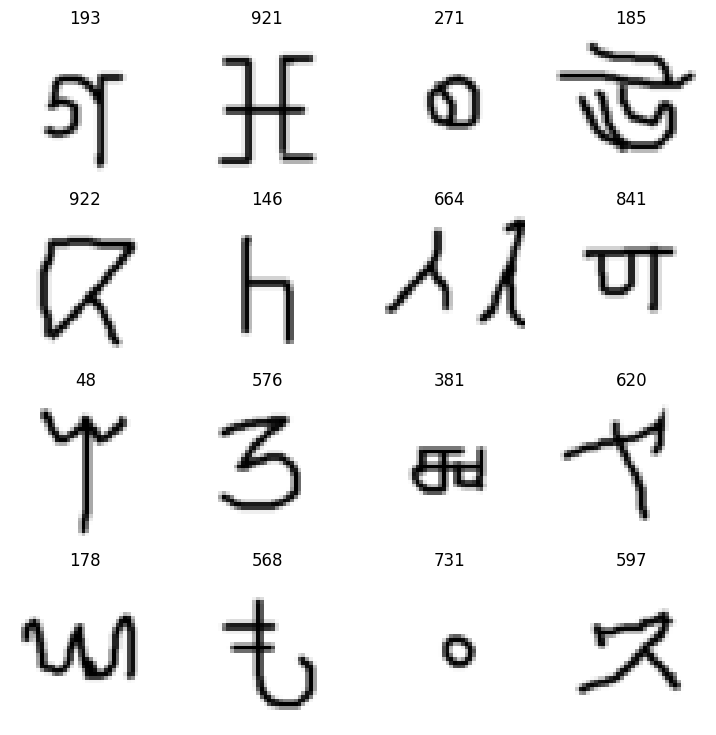

In [5]:
figure = plt.figure(figsize=(9, 9))
for i in range(1, 17):
    dataset_id = torch.randint(len(omniglot_tr), size=(1,)).item()
    img, label = omniglot_tr[dataset_id]
    figure.add_subplot(4, 4, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img[0], cmap="gray")
plt.show()

In [25]:
# loading the data
data_loader_tr = torch.utils.data.DataLoader(omniglot_tr,
                                             batch_size=len(omniglot_tr),
                                             shuffle=False)

train_data, train_labels = next(iter(data_loader_tr))

In [ ]:
# splitting the dataset into train and test
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=123)

In [8]:
train_data.size()

torch.Size([15424, 1, 40, 40])

In [9]:
train_labels.size()

torch.Size([15424])

In [10]:
test_data.size()

torch.Size([3856, 1, 40, 40])

In [11]:
test_labels.size()

torch.Size([3856])

In [70]:
#label_num = len(train_labels.unique())

In [10]:
label_num = 964

In [ ]:
# preprocessing data
train_data = abs(1 - train_data.squeeze())
test_data = abs(1 - test_data.squeeze())

In [ ]:
train_data.unique()

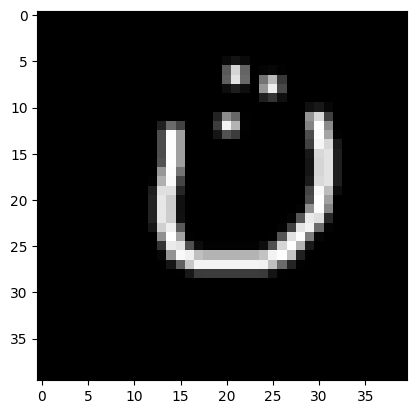

In [134]:
plt.imshow(train_data[0], cmap="gray")

# Data Augmentation // Preparation

Here i experiment with data augmentation

I have decided to apply simple affine and elastic transforms on training and test sets

I have tried not to go overboard (for example flipping the image) keeping in mind architecture of networks and limitations of my hardware

In [13]:
image_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomAffine(13),
    v2.ElasticTransform(),
    v2.ToDtype(torch.float32, scale=True),
])

## Example of tranformations

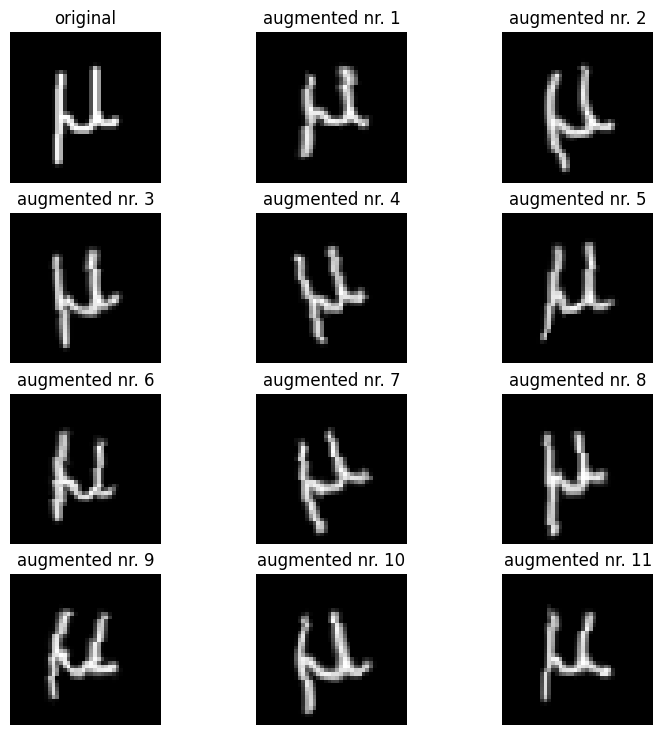

In [47]:
transformed_images = image_transforms(train_data[0])
labels_augmented_list = [train_labels[0].item()]

for _ in range(1, 12):
    transformed_image = image_transforms(train_data[0])
    transformed_images = torch.cat((transformed_images, transformed_image), 0)
    labels_augmented_list.append(train_labels[0])
    
labels_augmented = torch.tensor(labels_augmented_list)

figure = plt.figure(figsize=(9, 9))
figure.add_subplot(4, 3, 1)
plt.imshow(train_data[0], cmap="gray")
plt.axis("off")
plt.title('original')
for i in range(0, 11):
    img, label = transformed_images[i], f'augmented nr. {i+1}'
    figure.add_subplot(4, 3, i+2)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

In [141]:
augmented_training_data = []
augmented_training_labels = []
augmented_test_data = []
augmented_test_labels = []

num_of_repeats = 5

for i in range(0, len(train_data)):
    if i % 3000 == 0:
        print(f'Iteration : {i}')
    for _ in range(num_of_repeats):
        transformed_image = image_transforms(train_data[i])
        augmented_training_data.append(transformed_image)
        # augmented_training_data = torch.cat((augmented_training_data, transformed_image), 0)
        augmented_training_labels.append(train_labels[i].item())


for i in range(0, len(test_data)):
    if i % 3000 == 0:
        print(f'Iteration : {i}')
    for _ in range(num_of_repeats):
        transformed_image = image_transforms(test_data[i])
        augmented_test_data.append(transformed_image)
        # augmented_training_data = torch.cat((augmented_training_data, transformed_image), 0)
        augmented_test_labels.append(test_labels[i].item())

augmented_training_labels = torch.tensor(augmented_training_labels)
augmented_test_labels = torch.tensor(augmented_test_labels)

augmented_training_data = np.array(augmented_training_data)
augmented_training_data = torch.tensor(augmented_training_data).squeeze()
augmented_test_data = np.array(augmented_test_data)
augmented_test_data = torch.tensor(augmented_test_data).squeeze()

Iteration : 0
Iteration : 3000
Iteration : 6000
Iteration : 9000
Iteration : 12000
Iteration : 15000
Iteration : 0
Iteration : 3000


In [142]:
print(augmented_training_data.size())
print(augmented_training_labels.size())
print(augmented_test_data.size())
print(augmented_test_labels.size())

torch.Size([77120, 40, 40])
torch.Size([77120])
torch.Size([19280, 40, 40])
torch.Size([19280])


In [143]:
train_data = torch.cat((train_data, augmented_training_data), 0)
train_labels = torch.tensor(np.concatenate([np.array(train_labels), np.array(augmented_training_labels)]))
test_data = torch.cat((test_data, augmented_test_data), 0)
test_labels = torch.tensor(np.concatenate([np.array(test_labels), np.array(augmented_test_labels)]))

In [5]:
print(train_data.size())
print(train_labels.size())
print(test_data.size())
print(test_labels.size())

torch.Size([65124, 40, 40])
torch.Size([65124])
torch.Size([15276, 40, 40])
torch.Size([15276])


In [36]:
# saving the data
torch.save(train_data, "train_data.pt")
torch.save(train_labels, "train_labels.pt")
torch.save(test_data, "test_data.pt")
torch.save(test_labels, "test_labels.pt")

In [28]:
# loading the data
train_data = torch.load("train_data.pt")
train_labels = torch.load("train_labels.pt")
test_data = torch.load("test_data.pt")
test_labels = torch.load("test_labels.pt")

In [29]:
train_data = train_data.to(device)
train_labels = train_labels.to(device)
test_data = test_data.to(device)
test_labels = test_labels.to(device)

In [13]:
train_data_subset = train_data[0:50000]
train_labels_subset = train_labels[0:50000]

train_data_subset.to(device)
train_labels_subset.to(device)

tensor([259, 920, 115,  ..., 903, 903, 903], device='cuda:0')

# Reducing the dataset and augmenting it

Here I take first 20 labels (letters) from the dataset, and augment it by transforming each image five times. 
Then I merge original and augmented datasets together. 
(I repeat the same process for train and test sets separately)

## I have taken the following letters :

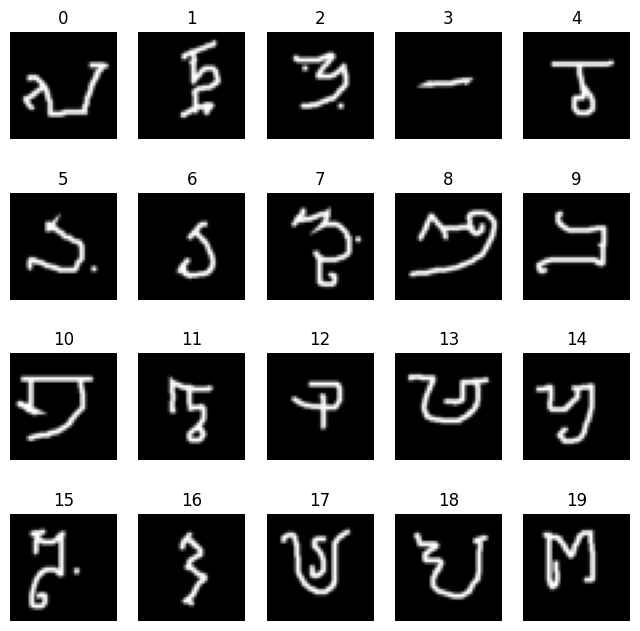

In [34]:
figure = plt.figure(figsize=(8, 8))
for i in range(0, 20):
    index = (train_labels == i).nonzero(as_tuple=True)[0][1].item()
    img, label = train_data[index].cpu(), train_labels[index].cpu()
    figure.add_subplot(4, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

In [12]:
num_of_labels = 20

In [ ]:
train_labels_supp = []
train_data_supp = []
test_labels_supp = []
test_data_supp = []

for i in range(num_of_labels):
    indexes = (train_labels == i).nonzero(as_tuple=True)[0]
    for j in range(len(indexes)):
        train_labels_supp.append(train_labels[indexes[j].item()])
        train_data_supp.append(train_data[indexes[j].item()])

for i in range(num_of_labels):
    indexes = (test_labels == i).nonzero(as_tuple=True)[0]
    for j in range(len(indexes)):
        test_labels_supp.append(test_labels[indexes[j].item()])
        test_data_supp.append(test_data[indexes[j].item()])
        
train_data = train_data_supp
train_labels = train_labels_supp
test_data = test_data_supp
test_labels = test_labels_supp

In [33]:
augmented_training_data = []
augmented_training_labels = []
augmented_test_data = []
augmented_test_labels = []

num_of_repeats = 200

for i in range(0, len(train_data)):
    if i % 50 == 0:
        print(f'Iteration : {i}')
    for _ in range(num_of_repeats):
        transformed_image = image_transforms(train_data[i])
        augmented_training_data.append(transformed_image)
        # augmented_training_data = torch.cat((augmented_training_data, transformed_image), 0)
        augmented_training_labels.append(train_labels[i].item())


for i in range(0, len(test_data)):
    if i % 20 == 0:
        print(f'Iteration : {i}')
    for _ in range(num_of_repeats):
        transformed_image = image_transforms(test_data[i])
        augmented_test_data.append(transformed_image)
        # augmented_training_data = torch.cat((augmented_training_data, transformed_image), 0)
        augmented_test_labels.append(test_labels[i].item())

augmented_training_labels = torch.tensor(augmented_training_labels)
augmented_test_labels = torch.tensor(augmented_test_labels)

augmented_training_data = np.array(augmented_training_data)
augmented_training_data = torch.tensor(augmented_training_data).squeeze()
augmented_test_data = np.array(augmented_test_data)
augmented_test_data = torch.tensor(augmented_test_data).squeeze()

Iteration : 0
Iteration : 50
Iteration : 100
Iteration : 150
Iteration : 200
Iteration : 250
Iteration : 300
Iteration : 0
Iteration : 20
Iteration : 40
Iteration : 60


In [35]:
train_data = torch.cat((torch.tensor(np.array(train_data)), torch.tensor(np.array(augmented_training_data))), 0)
train_labels = torch.tensor(np.concatenate([np.array(train_labels), np.array(augmented_training_labels)]))
test_data = torch.cat((torch.tensor(np.array(test_data)), torch.tensor(np.array(augmented_test_data))), 0)
test_labels = torch.tensor(np.concatenate([np.array(test_labels), np.array(augmented_test_labels)]))
print(train_data.size())
print(train_labels.size())
print(test_data.size())
print(test_labels.size())

torch.Size([65124, 40, 40])
torch.Size([65124])
torch.Size([15276, 40, 40])
torch.Size([15276])


# Hyperparameter tuning // Model selection

I have used a dataset with a lot more labels for hyperparameter tuning. For a lower number of labels over-fitting might be the problem. 
I was hoping data augmentation will help with over-fitting. 
However, it seems like with this type of data, probably because of a small initial dataset, over-fitting is still quite a problem.
I assume increasing the size of original (not augmented) images might help as well as maybe adding a convolutional layer?

I wasn't sure how to use a validation set for DBN as it is unsupervised, so I've judged by recreation error on training data.
It might be not the best approach, but at least this way I studied how well it captures the features in the training data.

During experimentation, I figured out the following:
- Models of type [1500, 1800, 2100], [1000, 1200, 1300] are probably the most effective
- Fourth layer seems unnecessary (as I later figured out even the third layer is unnecessary)
- Increasing the k for training phase seems to severely slow down training.
- xavier_init and increase_to_cd_k seem to slightly decrease recreation error in the third layer 

In [17]:
hidden_units = [
    [1500, 1800, 2100],
    [600, 750, 1000],
    [1700, 1700, 1700],
    [1500, 1200, 1000],
    [1500, 1600, 1800, 2300]
]

In [20]:
num_epochs = 50
batch_size = 160

for i in hidden_units:
    print(f'current model: {i}')

    dbn_omni = DBN(visible_units=40 * 40,
                    hidden_units=i,
                    k=1,
                    learning_rate=0.1,
                    learning_rate_decay=False,
                    initial_momentum=0.5,
                    final_momentum=0.95,
                    weight_decay=0.0001,
                    xavier_init=False,
                    increase_to_cd_k=False,
                    use_gpu=torch.cuda.is_available())

    dbn_omni.train_static(
        train_data_subset,
        train_labels_subset,
        num_epochs,
        batch_size
    )
    
    print(f'\n------------------------------\n')

current model: [1500, 1800, 2100]
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3129     |0.1320       |943.7963   |31.7594     |
|20    |1.1604     |0.1243       |961.2261   |27.1172     |
|30    |1.1190     |0.1224       |966.0942   |26.3334     |
|40    |1.0959     |0.1208       |960.8536   |28.6894     |
|50    |1.0889     |0.1197       |964.6931   |31.5986     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9580     |0.0565       |602.8849   |16.2755     |
|20    |0.8384     |0.0432       |573.1004   |18.2475     |
|30    |0.8172     |0.0416       |569.4417   |21.4109     |
|40    |0.8094     |0.0409       |570.3850   |22.3203     |
|50    |0.8052     |0.0417       |571.8655   |23.9282     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6715     |0.0503       |596.8369   |30.8966     |
|20   

In [15]:
k = [1, 2, 3]

In [16]:
num_epochs = 50
batch_size = 160

for i in k:
    print(f'current k: {i}')

    dbn_omni = DBN(visible_units=40 * 40,
                    hidden_units=[1500, 1800, 2100],
                    k=i,
                    learning_rate=0.1,
                    learning_rate_decay=False,
                    initial_momentum=0.5,
                    final_momentum=0.95,
                    weight_decay=0.0001,
                    xavier_init=False,
                    increase_to_cd_k=False,
                    use_gpu=torch.cuda.is_available())

    dbn_omni.train_static(
        train_data_subset,
        train_labels_subset,
        num_epochs,
        batch_size
    )

    print(f'\n------------------------------\n')

current k: 1
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3146     |0.1340       |940.8725   |36.9626     |
|20    |1.1575     |0.1213       |953.9941   |26.6383     |
|30    |1.1174     |0.1234       |961.9767   |26.6892     |
|40    |1.0966     |0.1185       |962.9006   |29.3492     |
|50    |1.0847     |0.1210       |956.2345   |29.0393     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9701     |0.0573       |592.6047   |15.1405     |
|20    |0.8402     |0.0434       |559.6799   |18.7054     |
|30    |0.8187     |0.0434       |554.9352   |21.0022     |
|40    |0.8093     |0.0423       |555.6760   |23.9288     |
|50    |0.8044     |0.0417       |555.2253   |24.6882     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6593     |0.0501       |596.9741   |28.6286     |
|20    |0.5866     |0.0409 

In [20]:
xavier_increase = [(False, False), (True, True), (True, False), (False, True)]

In [21]:
num_epochs = 50
batch_size = 160

for i in xavier_increase:
    print(f'xavier: {i[0]}, increase: {i[1]}')

    dbn_omni = DBN(visible_units=40 * 40,
                    hidden_units=[1500, 1800, 2100],
                    k=1,
                    learning_rate=0.1,
                    learning_rate_decay=False,
                    initial_momentum=0.5,
                    final_momentum=0.95,
                    weight_decay=0.0001,
                    xavier_init=i[0],
                    increase_to_cd_k=i[1],
                    use_gpu=torch.cuda.is_available())

    dbn_omni.train_static(
        train_data_subset,
        train_labels_subset,
        num_epochs,
        batch_size
    )

    print(f'\n------------------------------\n')

xavier: False, increase: False
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3069     |0.1284       |933.2698   |28.3242     |
|20    |1.1577     |0.1250       |952.9903   |29.5389     |
|30    |1.1182     |0.1220       |963.6375   |29.6061     |
|40    |1.0930     |0.1182       |954.3675   |25.8968     |
|50    |1.0856     |0.1212       |955.7208   |28.7074     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9661     |0.0565       |603.9123   |14.8349     |
|20    |0.8417     |0.0411       |574.8455   |19.3608     |
|30    |0.8164     |0.0418       |569.2938   |21.5033     |
|40    |0.8076     |0.0421       |570.2787   |23.7943     |
|50    |0.8075     |0.0419       |574.1210   |24.9463     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6702     |0.0495       |605.3264   |29.2918     |
|20    |0

# Main model

Trying both [1500, 1800, 2100] and [1000, 1200, 1300], I figured that they give approximately the same performance.
Therefore, I went with the model with lower number of neurons

It seems like the third layer is actually unnecessary, as the model captures features well already in the second layer (And I think over-fits)

In [19]:
num_epochs = 50
batch_size = 200

dbn_omni = DBN(visible_units=40 * 40,
               hidden_units=[800, 1000, 1200],
               k=1,
               learning_rate=0.1,
               learning_rate_decay=False,
               initial_momentum=0.5,
               final_momentum=0.95,
               weight_decay=0.0001,
               xavier_init=True,
               increase_to_cd_k=True,
               use_gpu=torch.cuda.is_available())

dbn_omni.train_static(
    train_data,
    train_labels,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |6.2124     |2.1315       |420.1357   |72.1674     |
|20    |5.8225     |2.0183       |397.5070   |69.1923     |
|30    |5.9393     |2.0092       |389.9370   |60.7681     |
|40    |5.8466     |1.9157       |367.6163   |41.9747     |
|50    |5.6399     |1.8320       |382.7376   |41.9035     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.2990     |0.1505       |99.4407   |10.9746     |
|20    |0.1440     |0.0783       |67.6089   |12.0557     |
|30    |0.1412     |0.0780       |64.6505   |12.8406     |
|40    |0.1340     |0.0714       |63.3496   |11.5799     |
|50    |0.1315     |0.0765       |60.7069   |13.1220     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6651     |0.2556       |137.9975   |26.1619     |
|20    |0.2349     |0.0774       |91.2029   |

# Clustering

In [18]:
# original data
#train_data = train_data[:19280]
#train_labels = train_labels[:19280]

#train_data = train_data.to(device)
#train_labels = train_labels.to(device)

In [20]:
def get_kth_layer_repr(input, k, device):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
    hidden_repr, __ = dbn_omni.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
    return hidden_repr

hidden_repr_1 = get_kth_layer_repr(train_data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)

In [86]:
def get_mask(label):  # we use this function to filter by class
    labels = train_labels.cpu().numpy()
    return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
    hidden_repr_np = hidden_repr.cpu().numpy()
    return {
        label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
        for label in range(20)
    }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
    label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
    return np.concatenate(
        [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
         for label in range(20)])

mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

def plot_dendrogram(mean_repr_matrix, title=""):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)

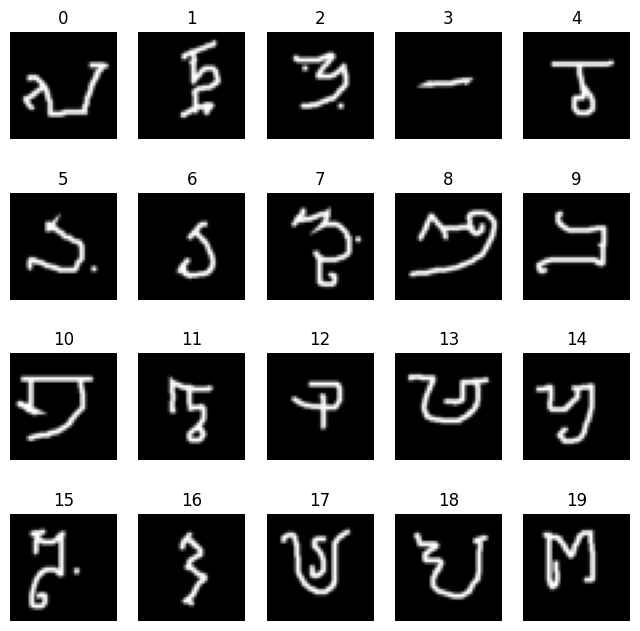

In [87]:
figure = plt.figure(figsize=(8, 8))
for i in range(0, 20):
    index = (train_labels == i).nonzero(as_tuple=True)[0][1].item()
    img, label = train_data[index].cpu(), train_labels[index].cpu()
    figure.add_subplot(4, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

## As for the clustering part
(examples of letters are above)

The following labels are the closest among the layers 
judging by representations from the (most accurate) second layer (examples are above):  

- 8 and 14 
- 2 and 7
- 5 and 9

Label 3 is the least similar, which makes sense. In fact, all three layers capture that fact rather easily.


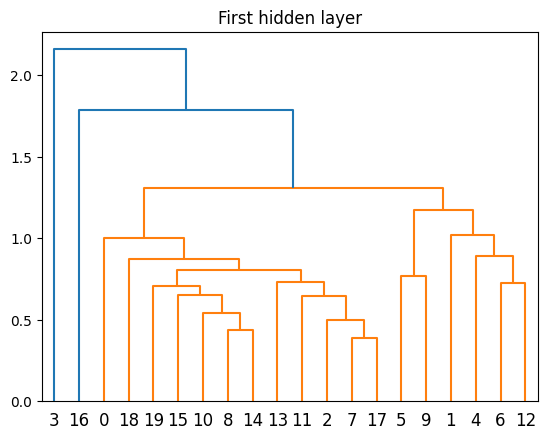

In [88]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

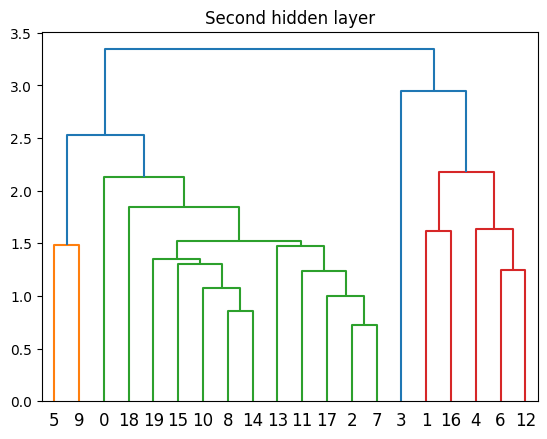

In [89]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

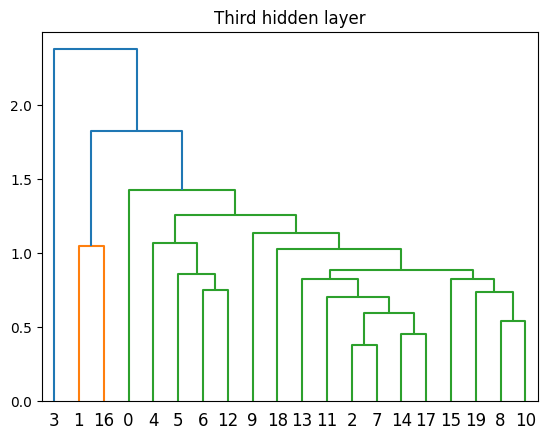

In [90]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

# Receptive Fields

Obtained receptive fields are not very simple and general
I'd suggest it might be due to the overfitting.
In other words, DBN captured the features a bit too well. 

In [71]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for im in range(num_subplots):
    row = im % n_rows_cols
    col = im // n_rows_cols
    axes[row, col].imshow(weights[im,:].reshape((40,40)), cmap=plt.cm.gray)  # here we select the weights we want to plot

In [72]:
w1 = get_weights(dbn_omni, layer=0)
w2 = get_weights(dbn_omni, layer=1)
w3 = get_weights(dbn_omni, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

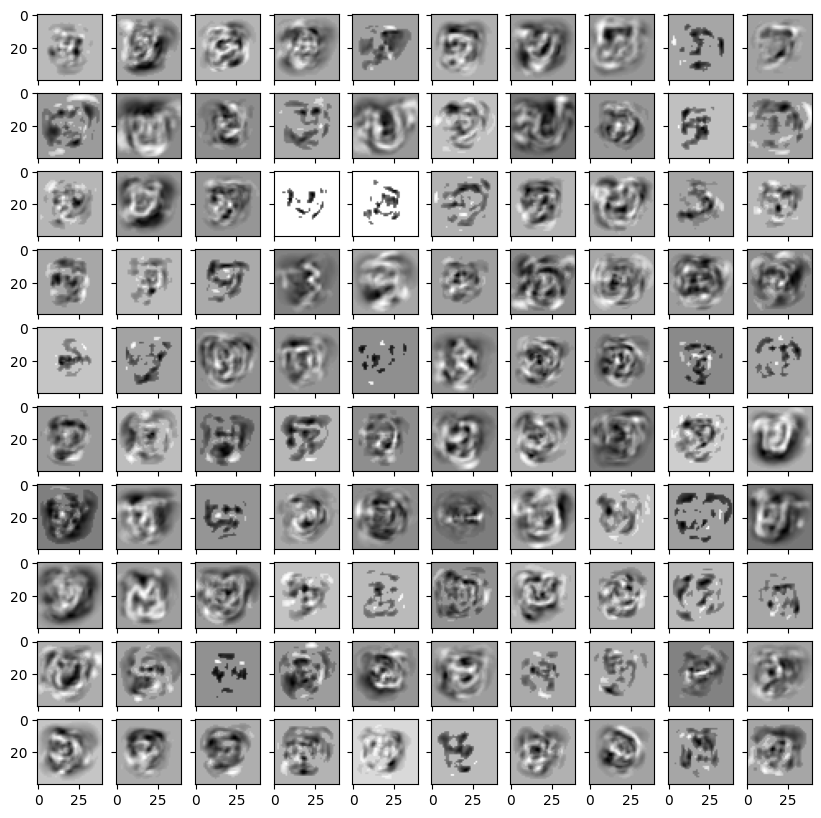

In [73]:
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

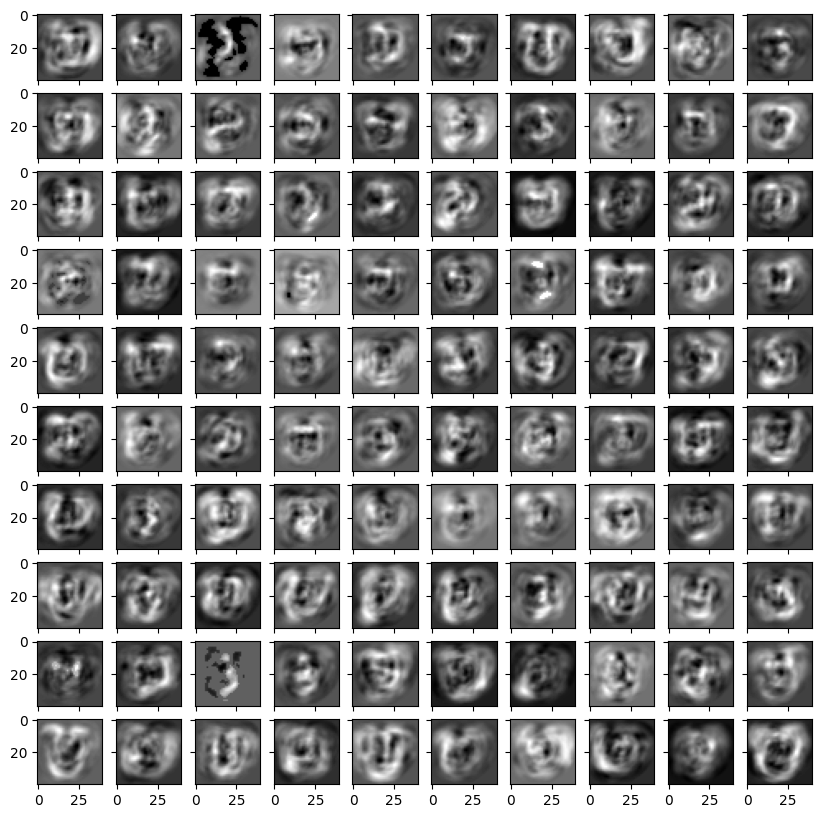

In [74]:
w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

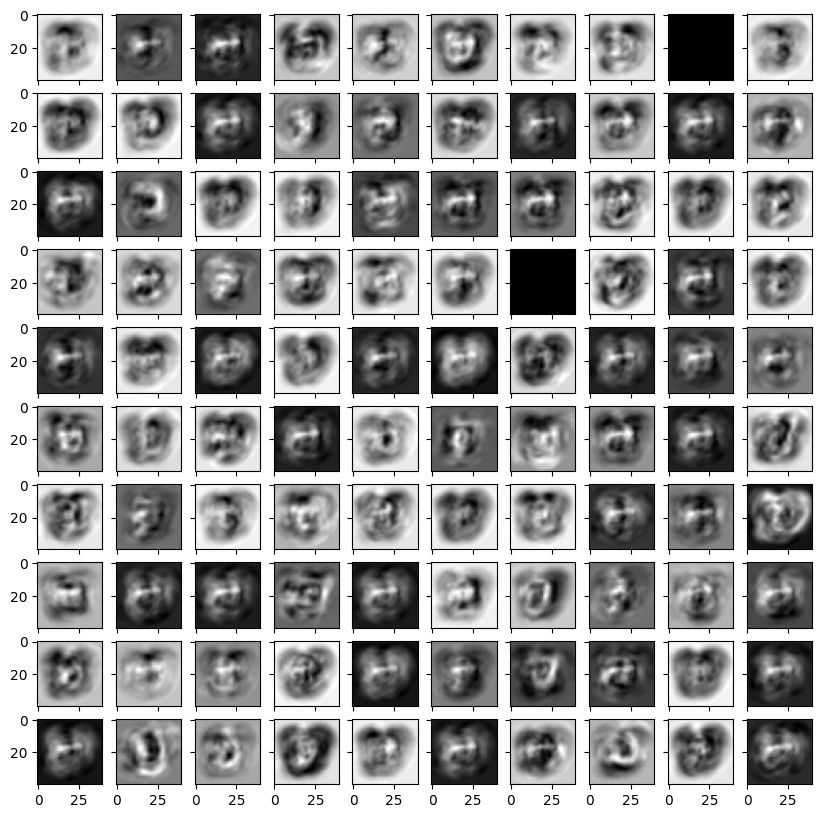

In [75]:
w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

# Linear readouts

In [21]:
class LinearModel(torch.nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(layer_size, num_of_labels)

    def forward(self, x):
        return self.linear(x)

In [22]:
layer_size = dbn_omni.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_omni.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_omni.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [23]:
def train_linear(linear, hidden_reprs, epochs=1000):
    optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = linear(hidden_reprs).squeeze()
        targets = train_labels.reshape(predictions.shape[0])# here are the labels
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [24]:
train_linear(linear1, hidden_repr_1)
train_linear(linear2, hidden_repr_2)
train_linear(linear3, hidden_repr_3)

epoch :   1/1000, loss = 3.0001
epoch : 101/1000, loss = 2.8834
epoch : 201/1000, loss = 2.7806
epoch : 301/1000, loss = 2.6908
epoch : 401/1000, loss = 2.6118
epoch : 501/1000, loss = 2.5410
epoch : 601/1000, loss = 2.4767
epoch : 701/1000, loss = 2.4178
epoch : 801/1000, loss = 2.3635
epoch : 901/1000, loss = 2.3132
epoch :   1/1000, loss = 3.0012
epoch : 101/1000, loss = 2.7225
epoch : 201/1000, loss = 2.5050
epoch : 301/1000, loss = 2.3308
epoch : 401/1000, loss = 2.1924
epoch : 501/1000, loss = 2.0812
epoch : 601/1000, loss = 1.9902
epoch : 701/1000, loss = 1.9141
epoch : 801/1000, loss = 1.8491
epoch : 901/1000, loss = 1.7929
epoch :   1/1000, loss = 2.9966
epoch : 101/1000, loss = 2.8548
epoch : 201/1000, loss = 2.7333
epoch : 301/1000, loss = 2.6301
epoch : 401/1000, loss = 2.5403
epoch : 501/1000, loss = 2.4603
epoch : 601/1000, loss = 2.3884
epoch : 701/1000, loss = 2.3232
epoch : 801/1000, loss = 2.2638
epoch : 901/1000, loss = 2.2095


In [25]:
hidden_repr_1_test = get_kth_layer_repr(test_data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [39]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [55]:
def convert_to_labels(predictions_test):
    predictions_indices = predictions_test.max(axis=1).indices
    return predictions_indices

In [57]:
predictions_test1_conv = convert_to_labels(predictions_test1)
predictions_test2_conv = convert_to_labels(predictions_test2)
predictions_test3_conv = convert_to_labels(predictions_test3)

In [82]:
def compute_accuracy(predictions_test, targets):
    predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

## As for the readouts,

It seems like the second layer is doing the best job and the third is quite unnecessary

In [83]:
compute_accuracy(predictions_test1, test_labels)

0.3989918828010559

In [84]:
compute_accuracy(predictions_test2, test_labels)

0.4569913446903229

In [85]:
compute_accuracy(predictions_test3, test_labels)

0.40082481503486633

# Feeed forward NN's (nr.1 and nr.2)

### To compare the models, I have decided to build two FFNN.

- one with the same layers as DBN
- looking at the performance of DBN I've decided to look at the FFNN with the same layers as DBN but without the third layer. 

In [104]:
train_data.size()

torch.Size([65124, 40, 40])

In [105]:
test_data.size()

torch.Size([15276, 40, 40])

In [26]:
class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
        super().__init__()
        self.first_hidden = torch.nn.Linear(1600, first_hidden_layer_size)
        self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output = torch.nn.Linear(third_hidden_layer_size, 20)

    def forward(self, input):
        relu = torch.nn.ReLU()
        first_hidden_repr = relu(self.first_hidden(input))
        second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
        third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
        output = self.output(third_hidden_repr)
        return output

In [30]:
ffnn = Feedforward(800, 1000, 1200).to(device)

train_linear(ffnn, train_data.reshape((65124, 1600)), 1050)

predictions_ffnn = ffnn(test_data.reshape((15276, 1600)))

compute_accuracy(predictions_ffnn, test_labels)

epoch :   1/1050, loss = 2.9958
epoch : 101/1050, loss = 2.9784
epoch : 201/1050, loss = 2.9380
epoch : 301/1050, loss = 2.7173
epoch : 401/1050, loss = 2.0418
epoch : 501/1050, loss = 1.3607
epoch : 601/1050, loss = 0.9967
epoch : 701/1050, loss = 0.7911
epoch : 801/1050, loss = 0.6402
epoch : 901/1050, loss = 0.5192
epoch : 1001/1050, loss = 0.4337


0.6468970775604248

In [32]:
class Feedforward2(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size):
        super().__init__()
        self.first_hidden = torch.nn.Linear(1600, first_hidden_layer_size)
        self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.output = torch.nn.Linear(second_hidden_layer_size, 20)

    def forward(self, input):
        relu = torch.nn.ReLU()
        first_hidden_repr = relu(self.first_hidden(input))
        second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
        output = self.output(second_hidden_repr)
        return output

In [33]:
ffnn2 = Feedforward2(800, 1000).to(device)

train_linear(ffnn2, train_data.reshape((65124, 1600)), 1050)

predictions_ffnn2 = ffnn2(test_data.reshape((15276, 1600)))

compute_accuracy(predictions_ffnn2, test_labels)

epoch :   1/1050, loss = 2.9963
epoch : 101/1050, loss = 2.8952
epoch : 201/1050, loss = 2.4362
epoch : 301/1050, loss = 1.5903
epoch : 401/1050, loss = 1.1029
epoch : 501/1050, loss = 0.8695
epoch : 601/1050, loss = 0.7266
epoch : 701/1050, loss = 0.6231
epoch : 801/1050, loss = 0.5424
epoch : 901/1050, loss = 0.4772
epoch : 1001/1050, loss = 0.4229


0.637470543384552

# Looking at feed-forward neural networks,

They seem to perform much better than DBN and in fact, NN with two layers seem to work in this case only slightly worse than with three.

In [113]:
def inject_noise(mnist_data, noise_level):
    noise = torch.randn(test_data.shape, device = device) * noise_level
    noisy_data = mnist_data + noise
    return noisy_data

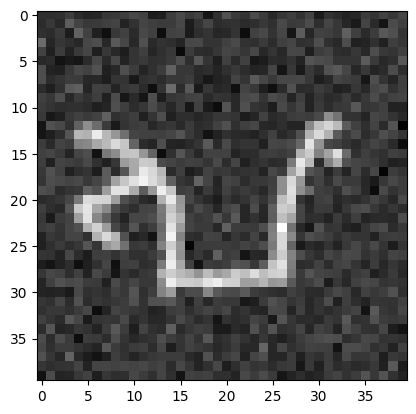

In [115]:
noise_level = 0.1
omni_test_with_noise = inject_noise(test_data, noise_level)
plt.imshow(omni_test_with_noise[1].reshape(40, 40).to("cpu"), cmap="gray")

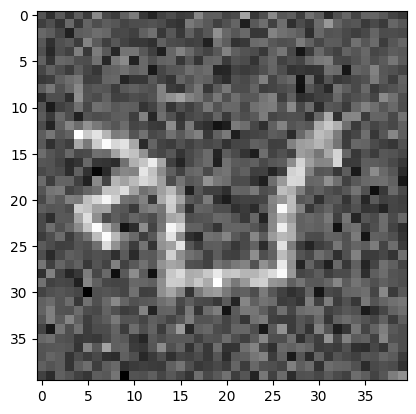

In [116]:
noise_level = 0.2
omni_test_with_noise = inject_noise(test_data, noise_level)
plt.imshow(omni_test_with_noise[1].reshape(40, 40).to("cpu"), cmap="gray")

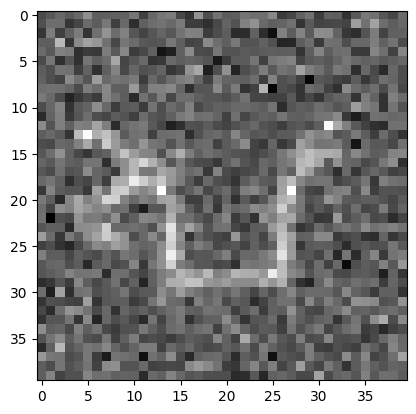

In [117]:
noise_level = 0.3
omni_test_with_noise = inject_noise(test_data, noise_level)
plt.imshow(omni_test_with_noise[1].reshape(40, 40).to("cpu"), cmap="gray")

# Robustness to noise

In [118]:
def get_accuracy_values_at_noise_level(noise_level):

    omni_test_with_noise = inject_noise(test_data, noise_level)  # first, let's create noisy test images

    hidden_repr_1_noisy = get_kth_layer_repr(omni_test_with_noise, 0, device)  # here we compute the DBN representations
    hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
    hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

    predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
    predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
    predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

    accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_labels)
    accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_labels)
    accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, test_labels)

    predictions__ffnn1 = ffnn(omni_test_with_noise.reshape((15276, 1600)))
    accuracy_ffnn1= compute_accuracy(predictions__ffnn1, test_labels)

    predictions__ffnn2 = ffnn2(omni_test_with_noise.reshape((15276, 1600)))
    accuracy_ffnn2= compute_accuracy(predictions__ffnn2, test_labels)

    return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn1, accuracy_ffnn2

In [119]:
acc = get_accuracy_values_at_noise_level(0.3)
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF1 network : %.3f" % acc[3])
print("Accuracy of FF2 network : %.3f" % acc[4])

Accuracy of H1 read-out: 0.386
Accuracy of H2 read-out: 0.438
Accuracy of H3 read-out: 0.386
Accuracy of FF1 network : 0.582
Accuracy of FF2 network : 0.584


In [122]:
def plot_noise_robustness_curves(noise_levels):
    accuracy_values_first_hidden = []
    accuracy_values_second_hidden = []
    accuracy_values_third_hidden = []
    accuracy_values_ffnn1 = []
    accuracy_values_ffnn2 = []

    for noise_level in noise_levels:
        acc = get_accuracy_values_at_noise_level(noise_level)
        accuracy_values_first_hidden.append(acc[0])
        accuracy_values_second_hidden.append(acc[1])
        accuracy_values_third_hidden.append(acc[2])
        accuracy_values_ffnn1.append(acc[3])
        accuracy_values_ffnn2.append(acc[4])

    fig, ax = plt.subplots()
    ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_ffnn1)
    ax.plot(range(len(noise_levels)), accuracy_values_ffnn2)

    ax.set_title("Robustness to noise")
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Accuracy")
    plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
    plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN1 (3 hidden layers)", "FFNN2 (2 hidden layers)"])

# As for robustness to noise 

The most robust in a long run is actually FFNN with 2 layers 
At some point, in fact second hidden layer of DBN outperforms one of the FFNNs which might signify that it actually might be more robust if it wouldn't overfit

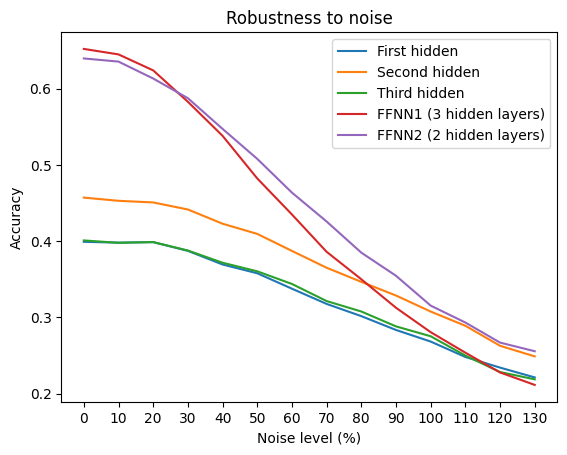

In [123]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

# Confusion matrices

As for confusion matrices, FFNNs are doing a considerably better job

DBNs are all having a problem mislabeling nr. 7 as nr. 2 for some reason
They also have no problem at all distinguishing nr. 3 from the others
We can actually see it in the way internal representations are clustered (7 and 2 are the most similar, 3 is the least similar with all other labels)

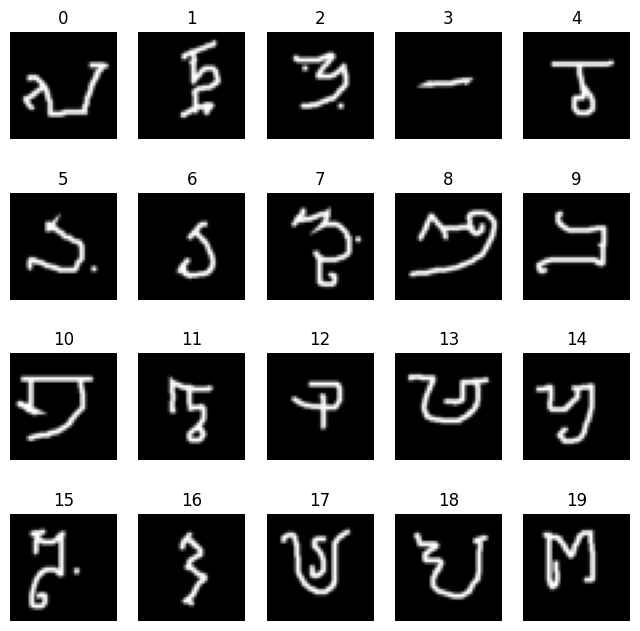

In [65]:
figure = plt.figure(figsize=(8, 8))
for i in range(0, 20):
    index = (train_labels == i).nonzero(as_tuple=True)[0][1].item()
    img, label = train_data[index].cpu(), train_labels[index].cpu()
    figure.add_subplot(4, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


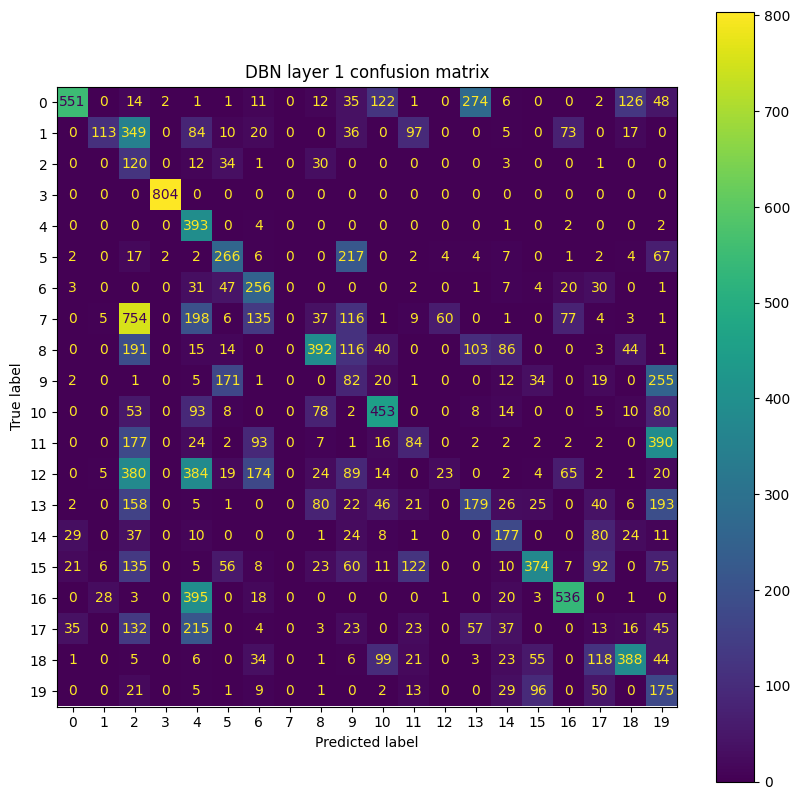

In [93]:
# DBN layer 1

mat = confusion_matrix(test_labels.cpu(), predictions_test1_conv.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('DBN layer 1 confusion matrix')
disp.plot(ax = ax)

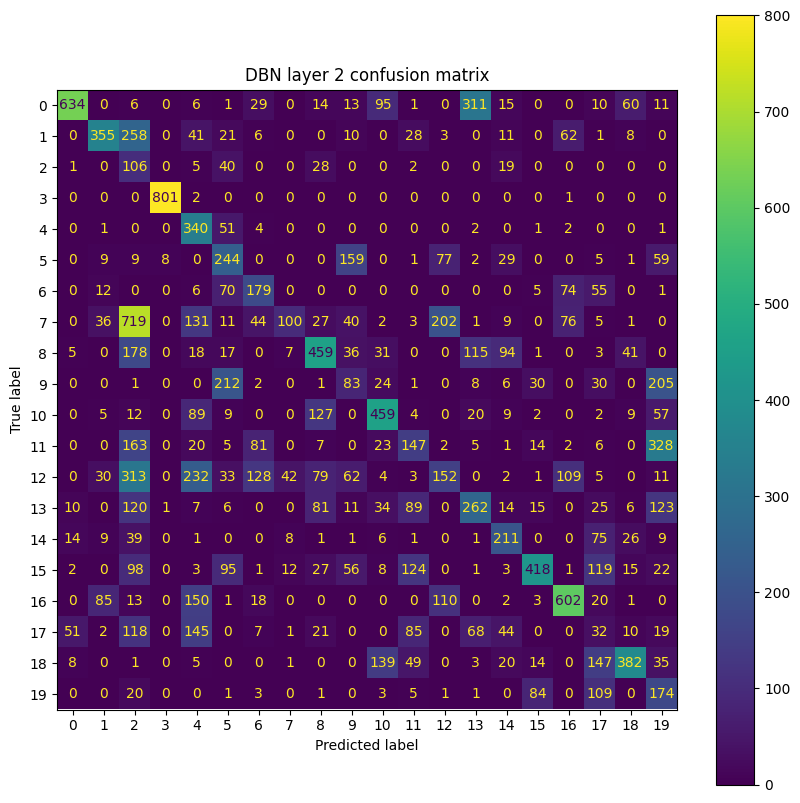

In [94]:
# DBN layer 2

mat = confusion_matrix(test_labels.cpu(), predictions_test2_conv.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('DBN layer 2 confusion matrix')
disp.plot(ax = ax)

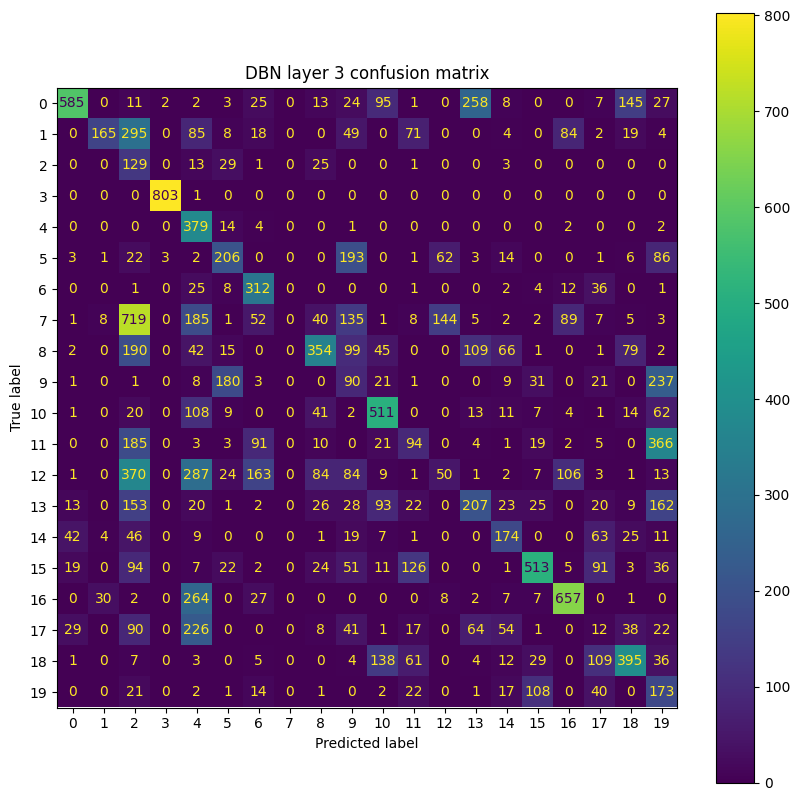

In [95]:
# DBN layer 3

mat = confusion_matrix(test_labels.cpu(), predictions_test3_conv.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('DBN layer 3 confusion matrix')
disp.plot(ax = ax)

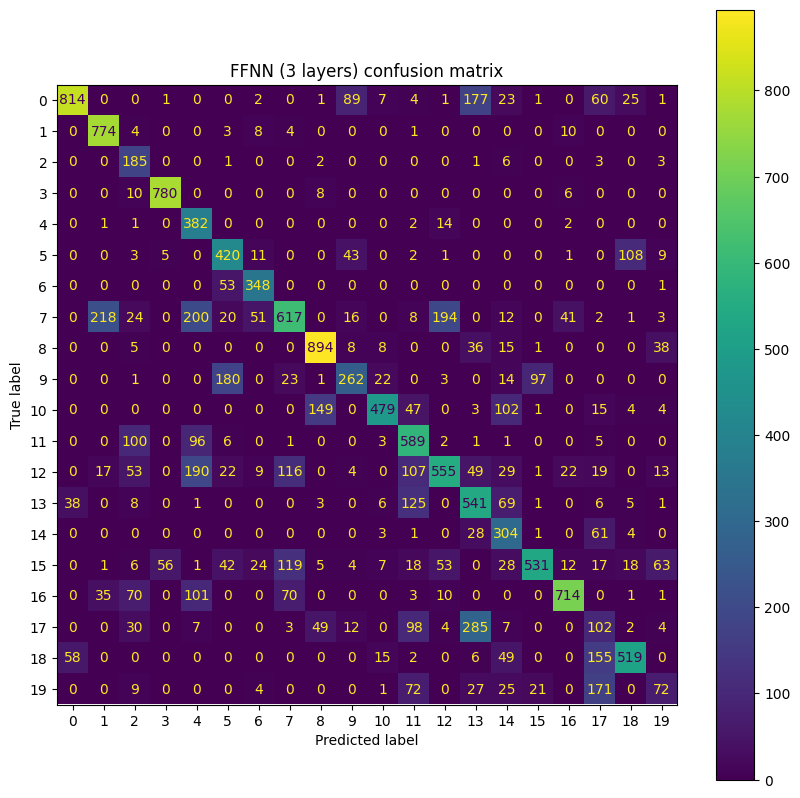

In [98]:
# FFNN 1 (3 layers)
predictions_ffnn = convert_to_labels(predictions_ffnn)

mat = confusion_matrix(test_labels.cpu(), predictions_ffnn.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('FFNN (3 layers) confusion matrix')
disp.plot(ax = ax)

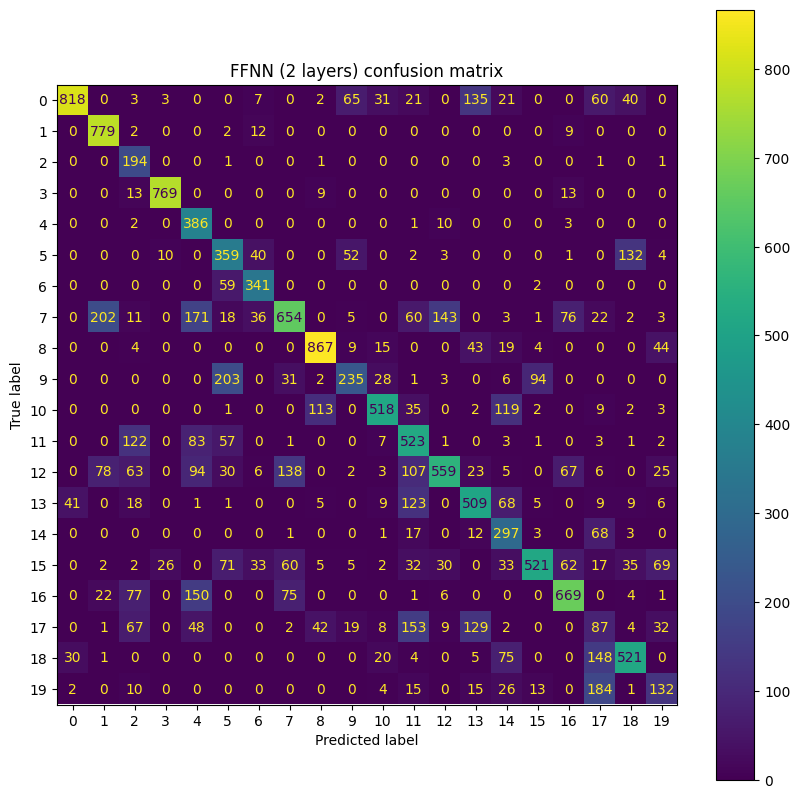

In [100]:
# FFNN 2 (2 layers)
predictions_ffnn2 = convert_to_labels(predictions_ffnn2)

mat = confusion_matrix(test_labels.cpu(), predictions_ffnn2.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
fig, ax = plt.subplots(figsize=(10,10))
plt.title('FFNN (2 layers) confusion matrix')
disp.plot(ax = ax)

# Adversarial attacks

When it comes to adversarial attacks, all three models seem to perform rather poorly
In case of DBN, increasing number of reconstruction steps does not really help. Probably due to the fact that the model is over-fitted and generally not very accurate.

As of possible defences this type of attack is performed knowing the gradient, so the good way will be not to expose the model to begin with. 
Other than that DBN can be proven useful when there's more unique data to train on and it does not over-fit. 


In [124]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    ### TASK: Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [135]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_omni, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_omni
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
        for rbm in self.dbn_mnist.rbm_layers:
            rbm.W.requires_grad_()
            rbm.h_bias.requires_grad_()

    def forward(self, image):
        """This forward pass uses probabilities instead of samples as RBM activations
         to backpropagate the gradient"""
        p_v = image
        hidden_states = []
        for rbm in self.dbn_mnist.rbm_layers:
            p_v = p_v.view((p_v.shape[0], -1))  # flatten
            p_v, v = rbm(p_v)
            hidden_states.append(p_v)
        return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [136]:
dbn_with_readout = DBNWithReadOut(dbn_omni, [linear1, linear2, linear3], readout_level=2)

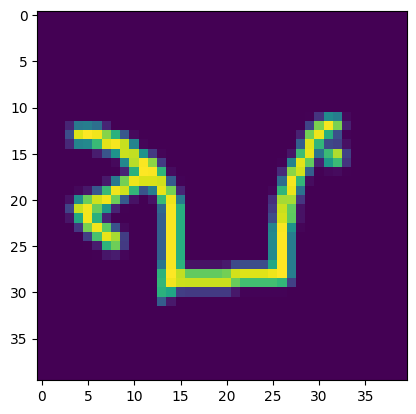

In [137]:
test_sample_idx = 1
test_image = test_data[test_sample_idx].reshape(1, 1600)
__ = plt.imshow(test_image.reshape(40,40).to('cpu'))

In [139]:
attacked_model = dbn_with_readout

In [140]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}. Ground label is {test_labels[test_sample_idx].item()}")

The prediction of the model for this clean sample is 0. Ground label is 0


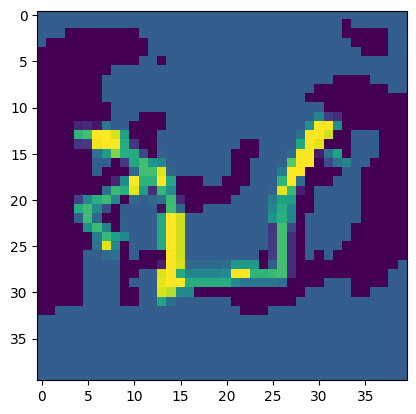

In [151]:
epsilon = 0.3
test_image_label = test_labels[test_sample_idx].unsqueeze(0)  
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  

perturbed_image = fgsm_attack(test_data[test_sample_idx].reshape(1, 1600), epsilon, image_grad)
plt.imshow(perturbed_image.reshape(40,40).to('cpu').numpy())

In [152]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 10.


In [183]:
def test_robustness_to_attack(model, device, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, print the result

    for data, target in zip(test_data, test_labels):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 1600)
        target = target.reshape(-1)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if print_reconstruction and verbose:
            print("\nHere's the original sample:\n")
            plt.imshow(data[0].detach().to('cpu').numpy().reshape(40, 40))
            plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if print_reconstruction and verbose:
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(40,40))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for _ in range(0, num_steps):
                perturbed_data, _ = model.dbn_mnist.reconstruct(perturbed_data)
            if print_reconstruction and verbose:
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(40,40))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_data))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [185]:
final_acc = test_robustness_to_attack(ffnn, device, epsilon=0,
                                      num_steps=0)


Epsilon: 0
Test Accuracy: 65.20%


In [186]:
final_acc = test_robustness_to_attack(ffnn, device, epsilon=0.1,
                                      num_steps=0)


Epsilon: 0.1
Test Accuracy: 3.26%


In [187]:
final_acc = test_robustness_to_attack(ffnn, device, epsilon=0.2,
                                      num_steps=0)


Epsilon: 0.2
Test Accuracy: 0.01%


In [188]:
final_acc = test_robustness_to_attack(ffnn2, device, epsilon=0,
                                      num_steps=0)


Epsilon: 0
Test Accuracy: 63.95%


In [189]:
final_acc = test_robustness_to_attack(ffnn2, device, epsilon=0.1,
                                      num_steps=0)


Epsilon: 0.1
Test Accuracy: 3.13%


In [190]:
final_acc = test_robustness_to_attack(ffnn2, device, epsilon=0.2,
                                      num_steps=0)


Epsilon: 0.2
Test Accuracy: 0.00%


In [193]:
final_acc = test_robustness_to_attack(dbn_with_readout, device, epsilon=0.2,
                                      num_steps=0)


Epsilon: 0.2
Test Accuracy: 4.69%



Here's the original sample:


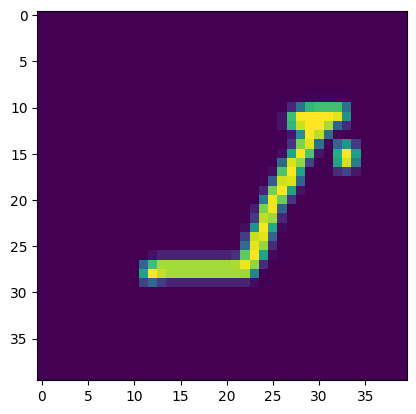


Here's a perturbed sample:


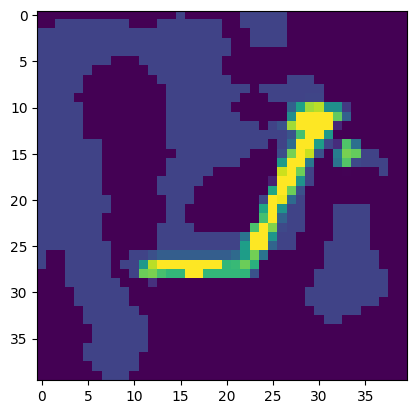


Here's what a 1-steps reconstructed sample looks like:


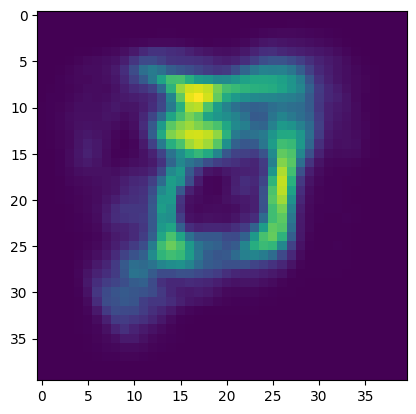


Epsilon: 0.2
Test Accuracy: 4.07%


In [195]:
final_acc = test_robustness_to_attack(dbn_with_readout, device, epsilon=0.2,
                                      num_steps=1)

In [197]:
test_data_sub1, test_data_sub2, test_labels_sub1, test_labels_sub2 = train_test_split(test_data, test_labels, test_size=0.1, random_state=123)

In [198]:
test_data_sub2.size()

torch.Size([1528, 40, 40])

In [199]:
test_labels_sub2.size()

torch.Size([1528])

In [202]:
test_data = test_data_sub2
test_labels = test_labels_sub2

In [200]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
    accuracies = list()

    for eps in epsilon_values:
        acc = test_robustness_to_attack(model, device, eps, num_steps=n_steps, verbose=False)
        accuracies.append(acc)

    return accuracies

In [203]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_ffnn2 = test_epsilon_values_effect(ffnn2, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

We can see accuracy drops quite fast, we can see reconstruction actually makes things worse in this case

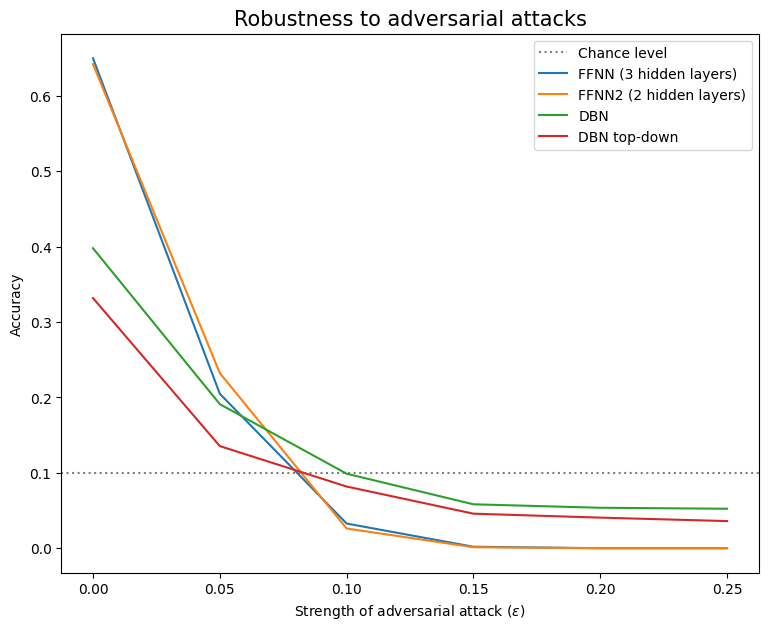

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

_ = ax.axhline(0.1, color='gray', linestyle=':')
_ = ax.plot(epsilon_values, accuracies_ffnn)
_ = ax.plot(epsilon_values, accuracies_ffnn2)
_ = ax.plot(epsilon_values, accuracies_dbn_0)
_ = ax.plot(epsilon_values, accuracies_dbn_1)
_ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
_ = ax.set_ylabel("Accuracy")
_ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
_ = ax.legend(["Chance level", "FFNN (3 hidden layers)", "FFNN2 (2 hidden layers)", "DBN", "DBN top-down"])

# Conclusion 